# 1. Importing Libraries and Data Set

In [1]:
# Importing the necessary libraries.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
import pyarrow as pa
import pyarrow.parquet as p
from datetime import datetime
from sas7bdat import SAS7BDAT
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from scipy.cluster.hierarchy import dendrogram
import umap
import umap.plot

2023-01-05 01:38:32.084652: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Importing the dataset.
with SAS7BDAT("a2z_insurance.sas7bdat", skip_header=False) as reader:
    df=reader.to_data_frame()

# 2. Data Exploration and Pre-Processing

## 2.1. Basic Data Exploration and Pre-Processing (Pre-Feature Engineering and Pre-Outlier Removal)

In [3]:
# Having a first look at the DataFrame.
df.head()

,CustID,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
0,1.0,1985.0,1982.0,2 - High School,2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
1,2.0,1981.0,1995.0,2 - High School,677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
2,3.0,1991.0,1970.0,1 - Basic,2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
3,4.0,1990.0,1981.0,3 - BSc/MSc,1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
4,5.0,1986.0,1973.0,3 - BSc/MSc,1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45


In [4]:
# Creating a copy of the original DataFrame, so that we don't lose it.
df1=df.copy()

In [5]:
# Setting the column "CustID" as the index.
df1.set_index("CustID",inplace=True)

In [6]:
# Checking the number of rows and columns.
# We have 10296 observations and 13 variables, at first.
df1.shape

(10296, 13)

In [7]:
# Checking other useful information from our DataFrame.
df1.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 10296 entries, 1.0 to 10296.0
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FirstPolYear   10266 non-null  float64
 1   BirthYear      10279 non-null  float64
 2   EducDeg        10296 non-null  object 
 3   MonthSal       10260 non-null  float64
 4   GeoLivArea     10295 non-null  float64
 5   Children       10275 non-null  float64
 6   CustMonVal     10296 non-null  float64
 7   ClaimsRate     10296 non-null  float64
 8   PremMotor      10262 non-null  float64
 9   PremHousehold  10296 non-null  float64
 10  PremHealth     10253 non-null  float64
 11  PremLife       10192 non-null  float64
 12  PremWork       10210 non-null  float64
dtypes: float64(12), object(1)
memory usage: 1.1+ MB


In [8]:
# Checking some descriptive statistics using the .describe() method.
# From here we can already check the existence of some outliers, and other values
# that look a bit non-sense at first. We will analyse them better during
# the report.
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
FirstPolYear,10266.0,1991.062634,511.267913,1974.00,1980.00,1986.00,1992.0000,53784.00
BirthYear,10279.0,1968.007783,19.709476,1028.00,1953.00,1968.00,1983.0000,2001.00
MonthSal,10260.0,2506.667057,1157.449634,333.00,1706.00,2501.50,3290.2500,55215.00
GeoLivArea,10295.0,2.709859,1.266291,1.00,1.00,3.00,4.0000,4.00
Children,10275.0,0.706764,0.455268,0.00,0.00,1.00,1.0000,1.00
CustMonVal,10296.0,177.892605,1945.811505,-165680.42,-9.44,186.87,399.7775,11875.89
ClaimsRate,10296.0,0.742772,2.916964,0.00,0.39,0.72,0.9800,256.20
PremMotor,10262.0,300.470252,211.914997,-4.11,190.59,298.61,408.3000,11604.42
PremHousehold,10296.0,210.431192,352.595984,-75.00,49.45,132.80,290.0500,25048.80
PremHealth,10253.0,171.580833,296.405976,-2.11,111.80,162.81,219.8200,28272.00


In [9]:
# Checking for how many missing values we have in each column.
df1.isna().sum()

FirstPolYear      30
BirthYear         17
EducDeg            0
MonthSal          36
GeoLivArea         1
Children          21
CustMonVal         0
ClaimsRate         0
PremMotor         34
PremHousehold      0
PremHealth        43
PremLife         104
PremWork          86
dtype: int64

In [10]:
# Checking if we have any duplicated row.
sum(df1.duplicated())

3

In [11]:
# In fact we have 3 pairs of repeated rows.
df1[df1.duplicated(keep=False)]

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
2076.0,1977.0,1974.0,2 - High School,2204.0,4.0,1.0,-22.11,1.00,214.93,88.90,266.94,39.23,42.12
2100.0,1987.0,1987.0,2 - High School,1912.0,4.0,1.0,290.61,0.58,202.37,177.25,306.39,63.90,-0.11
3507.0,1986.0,1952.0,2 - High School,3900.0,4.0,0.0,-119.35,1.10,163.03,481.75,224.82,94.35,18.56
8014.0,1987.0,1987.0,2 - High School,1912.0,4.0,1.0,290.61,0.58,202.37,177.25,306.39,63.90,-0.11
8122.0,1977.0,1974.0,2 - High School,2204.0,4.0,1.0,-22.11,1.00,214.93,88.90,266.94,39.23,42.12
9554.0,1986.0,1952.0,2 - High School,3900.0,4.0,0.0,-119.35,1.10,163.03,481.75,224.82,94.35,18.56


In [12]:
# Dropping each one of the three repeated observations.
df1.drop([2076.0,2100.0,3507.0],axis=0,inplace=True)

In [13]:
# Only the column "EducDeg" has empty values.
for x in list(df1.columns):
    print(df1[df1[x]==""].shape[0])

0
0
17
0
0
0
0
0
0
0
0
0
0


In [14]:
# Let's have a look which rows have an empty value in the column "EducDeg":
df1[df1["EducDeg"]==""]

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
897.0,NaN,1960.0,,2643.0,1.0,1.0,-25.00,1.00,515.54,33.90,47.01,12.89,3.78
1708.0,1992.0,1946.0,,3827.0,4.0,0.0,355.52,0.33,222.71,146.70,NaN,94.13,105.24
2450.0,NaN,1939.0,,4465.0,4.0,0.0,457.75,0.36,338.73,187.25,175.81,43.23,4.78
2729.0,NaN,1954.0,,3200.0,2.0,0.0,109.25,0.77,211.93,14.45,275.72,77.68,11.67
2771.0,NaN,1984.0,,1473.0,4.0,1.0,443.74,0.31,386.74,104.45,156.92,5.00,27.45
3057.0,NaN,1977.0,,2221.0,1.0,1.0,-9.22,0.97,475.09,15.00,93.35,15.78,2.78
4424.0,NaN,1962.0,,2688.0,1.0,1.0,481.99,0.09,533.99,-30.00,52.01,3.00,NaN
6536.0,NaN,1968.0,,2413.0,3.0,1.0,420.86,0.28,472.31,48.35,56.90,26.45,16.67
6561.0,1976.0,1992.0,,NaN,4.0,1.0,85.91,0.77,91.24,0.00,227.60,60.01,110.91


In [15]:
# Checking all the existing values in column "EducDeg".
df1["EducDeg"].value_counts()

3 - BSc/MSc        4799
2 - High School    3507
1 - Basic          1272
4 - PhD             698
                     17
Name: EducDeg, dtype: int64

In [16]:
# As of now, we are going to assume that the empty ones are the ones with no Education,
# and so we are going to fill them with "1 - Basic". It doesn't make to create
# a new value, for example "0 - No Education" as it only represents 17 observations.
df1.loc[(df1["EducDeg"]==""),"EducDeg"]="1 - Basic"

In [17]:
# As we can see the column "EducDeg" was filled.
df1[df1["EducDeg"]=="1 - Basic"].head()

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
3.0,1991.0,1970.0,1 - Basic,2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
14.0,1983.0,2000.0,1 - Basic,1043.0,3.0,1.0,-75.12,1.06,44.34,342.85,127.69,267.94,94.46
19.0,1981.0,1982.0,1 - Basic,1414.0,3.0,1.0,230.38,0.71,313.17,373.40,121.80,14.78,72.57
81.0,1980.0,1961.0,1 - Basic,2318.0,4.0,1.0,14.34,0.95,355.51,304.50,136.58,39.34,21.67
92.0,1993.0,1939.0,1 - Basic,3903.0,3.0,0.0,238.94,0.64,263.94,196.15,221.93,31.34,29.56


In [18]:
# We can consider education an ordinal variable, and so we are going
# to transform it, so that then we can use it for our analyses and posterior
# clustering. "1 - Basic" will be the 1, "2 - High School" will be the 2, "3 - BSc/MSc" will be the 3,
# and finally "4 - PhD" will be the 4.
df1.loc[(df1["EducDeg"]=="1 - Basic"),"EducDeg"]=1
df1.loc[(df1["EducDeg"]=="2 - High School"),"EducDeg"]=2
df1.loc[(df1["EducDeg"]=="3 - BSc/MSc"),"EducDeg"]=3
df1.loc[(df1["EducDeg"]=="4 - PhD"),"EducDeg"]=4

In [19]:
# Checking if the change went alright.
df1["EducDeg"].value_counts()

3    4799
2    3507
1    1289
4     698
Name: EducDeg, dtype: int64

In [20]:
# Defining and having a look to the rows which have columns that contain null values,
# not that we fixed the empty values.
nans_index=df1.isna().any(axis=1)
df1[nans_index].head()

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
22.0,1977.0,1958.0,2,NaN,3.0,1.0,111.37,0.80,407.52,111.70,100.13,24.67,30.34
69.0,1983.0,1977.0,2,1399.0,4.0,1.0,476.65,0.33,330.73,186.70,211.15,NaN,15.78
139.0,1979.0,1976.0,2,2538.0,2.0,1.0,149.59,0.69,194.26,305.60,NaN,37.34,17.67
144.0,1996.0,1990.0,3,NaN,4.0,1.0,-42.45,1.02,146.36,353.95,220.04,121.80,42.01
185.0,1993.0,1984.0,2,2419.0,4.0,1.0,-62.23,1.07,NaN,253.95,230.60,5.89,43.12


In [21]:
# Seeing if any feature in any row have the value "None".
# We conclude that we don't have none values in any feature of any observation.
for x in df1.columns:
    print(sum(df1[x]==None))

0
0
0
0
0
0
0
0
0
0
0
0
0


In [22]:
# As of now we will use KNNImputer to fill the null values of the metric features. To correctly use
# KNNImputer and since it uses Euclidean Distance, we will have to scale the data temporarily.
# We will be using MinMaxScaler() and after imputing with KNN we invert the scaling
# so that we don't lose interpretation.
metric_features=['FirstPolYear', 'BirthYear', 'MonthSal',
       'CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold',
       'PremHealth', 'PremLife', 'PremWork']
min_max=MinMaxScaler()
min_max.fit(df1[metric_features])
df1[metric_features]=min_max.transform(df1[metric_features])
df1[metric_features].head()

,FirstPolYear,BirthYear,MonthSal,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,
1.0,0.000212,0.980473,0.033599,0.935260,0.001522,0.032731,0.006148,0.005251,0.133259,0.014440
2.0,0.000135,0.993834,0.006268,0.932376,0.004372,0.007027,0.019551,0.004202,0.497113,0.059044
3.0,0.000328,0.968140,0.035421,0.935957,0.001093,0.018113,0.011921,0.004481,0.230323,0.055491
4.0,0.000309,0.979445,0.013957,0.933019,0.003864,0.016074,0.004711,0.011080,0.104466,0.020163
5.0,0.000232,0.971223,0.026056,0.933313,0.003513,0.029524,0.004888,0.006532,0.063607,0.026716


In [23]:
# Applying now the KNNImputer to the missing values.
imputer=KNNImputer(n_neighbors=5,weights="uniform")
imputer.fit(df1[metric_features])
df1[metric_features]=imputer.transform(df1[metric_features])

In [24]:
# Inverting the scaling, as we don't want to lose interpretability of the data.
df1[metric_features]=min_max.inverse_transform(df1[metric_features])
df1.head()

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
1.0,1985.0,1982.0,2,2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
2.0,1981.0,1995.0,2,677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
3.0,1991.0,1970.0,1,2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
4.0,1990.0,1981.0,3,1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
5.0,1986.0,1973.0,3,1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45


In [25]:
# Using the mode to fill the null values in the non metric features.
non_metric_features=["EducDeg", "GeoLivArea", "Children"]
modes=df1[non_metric_features].mode().loc[0]
df1.fillna(modes, inplace=True)

In [26]:
# We no longer have any null value.
df1.isna().sum()

FirstPolYear     0
BirthYear        0
EducDeg          0
MonthSal         0
GeoLivArea       0
Children         0
CustMonVal       0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
dtype: int64

In [27]:
# As we can see the previous null values were fixed.
df1[nans_index].head()

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
22.0,1977.0,1958.0,2,2950.4,3.0,1.0,111.37,0.80,407.520,111.70,100.13,24.67,30.34
69.0,1983.0,1977.0,2,1399.0,4.0,1.0,476.65,0.33,330.730,186.70,211.15,15.67,15.78
139.0,1979.0,1976.0,2,2538.0,2.0,1.0,149.59,0.69,194.260,305.60,242.89,37.34,17.67
144.0,1996.0,1990.0,3,1254.4,4.0,1.0,-42.45,1.02,146.360,353.95,220.04,121.80,42.01
185.0,1993.0,1984.0,2,2419.0,4.0,1.0,-62.23,1.07,285.432,253.95,230.60,5.89,43.12


In [28]:
# Checking how many columns have a policy year lower than the birth year.
sum(df1["FirstPolYear"]<(df1["BirthYear"]))

2042

In [29]:
# Before applying KNNImputer we had 2003 observations that had a first policy year lower than
# the birth year, and after applying the KNNImputer, this number rises to 2042 observations.
# This has to be an error in the data and will be dealth with after further analysis.
strange_rows=df1[df1["FirstPolYear"]<df1["BirthYear"]]

In [30]:
# Checking the rows where "FirstPolYear" is earlier than the "BirthYear".
df1.loc[strange_rows.index,:].head()

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
2.0,1981.0,1995.0,2,677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
14.0,1983.0,2000.0,1,1043.0,3.0,1.0,-75.12,1.06,44.34,342.85,127.69,267.94,94.46
19.0,1981.0,1982.0,1,1414.0,3.0,1.0,230.38,0.71,313.17,373.40,121.80,14.78,72.57
21.0,1986.0,1986.0,4,1704.0,4.0,1.0,373.73,0.39,329.84,65.00,221.93,3.89,33.34
23.0,1976.0,1986.0,2,1495.0,1.0,1.0,-89.79,1.08,209.04,308.95,192.48,64.79,54.90


In [31]:
# Converting "FirstPolYear" and "BirthYear"
# to the right datatype as they have to be integers and not floats. Before we couldn't
# perform this as we had null values in our observations. We couldn't round it before
# because at first we had a couple of null values in the first policy year and birth year
# column.
df1["FirstPolYear"]=df1["FirstPolYear"].astype("int")
df1["BirthYear"]=df1["BirthYear"].astype("int")
df1["GeoLivArea"]=df1["GeoLivArea"].astype("int")
df1["Children"]=df1["Children"].astype("int")

In [32]:
# Having an overview of the DataFrame resulting from the Data Exploration and Pre-Processing Part I.
df1.head()

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
1.0,1985,1981,2,2177.0,1,1,380.97,0.39,375.85,79.45,146.36,47.01,16.89
2.0,1981,1995,2,677.0,4,1,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
3.0,1991,1970,1,2277.0,3,0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
4.0,1990,1981,3,1099.0,4,1,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
5.0,1985,1973,3,1763.0,4,1,35.23,0.90,338.62,47.80,182.59,18.78,41.45


In [33]:
# At the moment we have several problems being them: Still having to deal with
# the problem of observations with a value in "FirstPolYear" lower than in "BirthYear".

## 2.2. Advanced Data Exploration and Pre-Processing (Feature Engineering and Outlier Removal)

### 2.2.1. Outlier Removal

In [34]:
# Creating a copy of our previous DataFrame as we are going to perform
# outlier removal in the metric features.
df2=df1.copy()

In [35]:
# When we start the clustering we may have to adapt the quantity of outliers
# we include according to the clustering techniques we are using
# since some of them adapt better to outliers than others. Also, we may
# test how the clustering goes when using 3, 4, 5 standard deviations
# because for now is hard to tell how many outliers should we exclude.

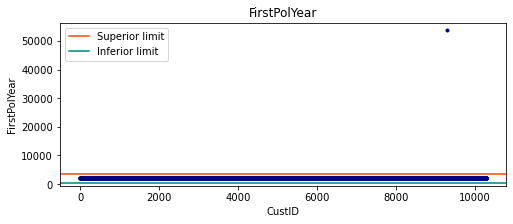

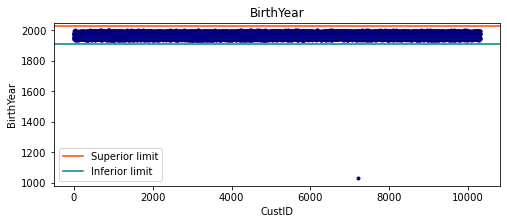

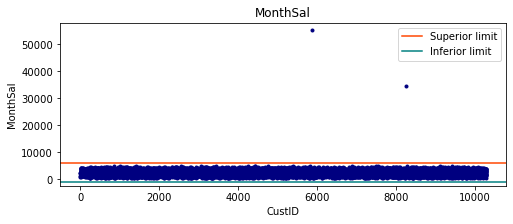

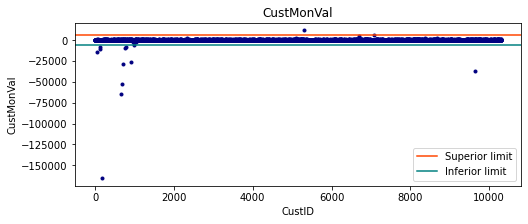

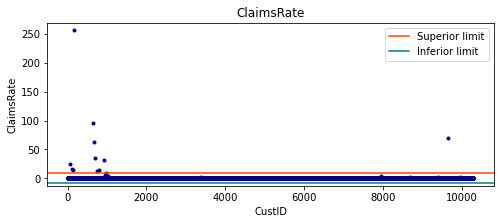

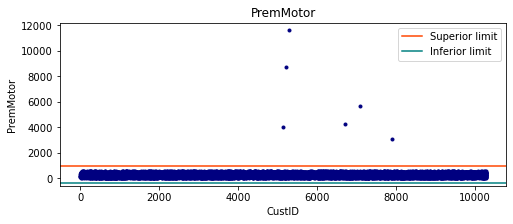

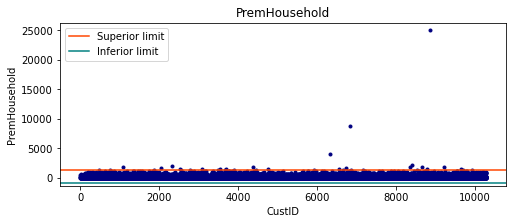

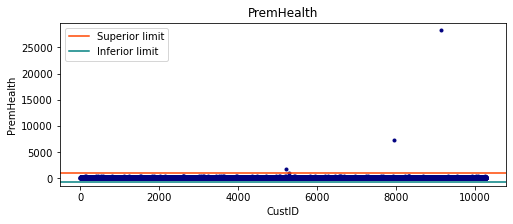

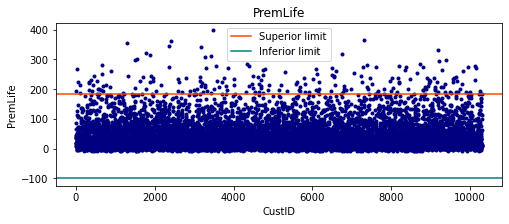

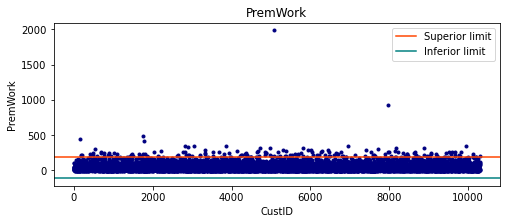

In [36]:
# Plotting every point in a chart and introducing an upper and lower limit
# corresponding to 3 standard deviations above and below the mean. This will
# help us understand better which observations are outliers. For some features we may have
# to increase/decrease this upper/lower limit as it can be dropping too many or
# too little outliers. Let's have a first look for every metric feature.
for feature in metric_features:
    
    sup_lim = df2[feature].mean() + 3*df2[feature].std()
    inf_lim = df2[feature].mean() - 3*df2[feature].std()

    plt.figure(figsize = (8, 3))
    plt.plot(df2[feature], 'o', ms = 3, color = 'navy')
    plt.autoscale(enable=True)
    plt.axhline(sup_lim,color = 'orangered',label='Superior limit')
    plt.axhline(inf_lim,color = 'teal',label='Inferior limit')
    plt.xlabel('CustID')
    plt.ylabel(feature)
    plt.legend()
    plt.title(feature)

In [37]:
# Not considering some of this observations as outliers would mean that they would have
# an own cluster for themselves, but then since they are little represented we wouldn't be
# that interested in creating a marketing strategy for them. For example, the 13 observations
# we are taking out do to "CustMonValue" having extreme values is people that used claimed the
# insurance and received large amounts of money, being financial disastrous for the insurance
# company.

for feature in metric_features:
    
    sup_lim = df2[feature].mean() + 3*df2[feature].std()
    inf_lim = df2[feature].mean() - 3*df2[feature].std()
    out=sum((df2[feature]>sup_lim) + (df2[feature]<inf_lim))
    
    print(f"Keeping this threshold for {feature}, we eliminate {out} outliers.")

Keeping this threshold for FirstPolYear, we eliminate 1 outliers.
Keeping this threshold for BirthYear, we eliminate 1 outliers.
Keeping this threshold for MonthSal, we eliminate 2 outliers.
Keeping this threshold for CustMonVal, we eliminate 13 outliers.
Keeping this threshold for ClaimsRate, we eliminate 12 outliers.
Keeping this threshold for PremMotor, we eliminate 6 outliers.
Keeping this threshold for PremHousehold, we eliminate 36 outliers.
Keeping this threshold for PremHealth, we eliminate 3 outliers.
Keeping this threshold for PremLife, we eliminate 210 outliers.
Keeping this threshold for PremWork, we eliminate 162 outliers.


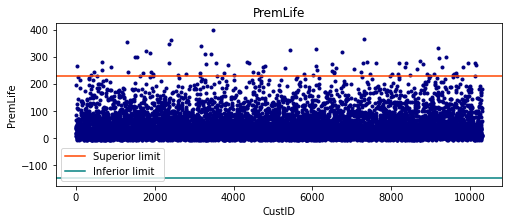

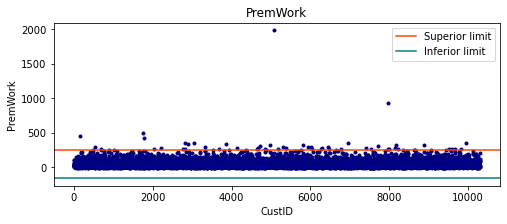

In [38]:
# For every metric feature it looks like if we use 3 standard deviations
# we are eliminating the right number of outliers. For "PremLife" and "PremWork"
# it looks like we are eliminating too many outliers. For these 2 features we are
# going to increase the threshold to 4 standard deviations and plot the result, as we
# don't want to eliminate real extreme values but only values that are harder to find
# sense on.
for feature in ["PremLife","PremWork"]:
    
    sup_lim = df2[feature].mean() + 4*df2[feature].std()
    inf_lim = df2[feature].mean() - 4*df2[feature].std()

    plt.figure(figsize = (8, 3))
    plt.plot(df2[feature], 'o', ms = 3, color = 'navy')
    plt.autoscale(enable=True)
    plt.axhline(sup_lim,color = 'orangered',label='Superior limit')
    plt.axhline(inf_lim,color = 'teal',label='Inferior limit')
    plt.xlabel('CustID')
    plt.ylabel(feature)
    plt.legend()
    plt.title(feature)

In [39]:
# Using 4 standard deviations the elimination of outliers for "PremLife"
# and "PremWork" is much more smooth.

for feature in ["PremLife","PremWork"]:
    
    sup_lim = df2[feature].mean() + 4*df2[feature].std()
    inf_lim = df2[feature].mean() - 4*df2[feature].std()
    out=sum((df2[feature]>sup_lim) + (df2[feature]<inf_lim))
    
    print(f"Keeping this threshold for {feature}, we eliminate {out} outliers.")

Keeping this threshold for PremLife, we eliminate 79 outliers.
Keeping this threshold for PremWork, we eliminate 62 outliers.


In [40]:
# Removal of the outliers. We eliminate 2% of the outliers, which is an acceptable
# number given the size of the dataset.

for feature in ['FirstPolYear','BirthYear','MonthSal','CustMonVal',
                'ClaimsRate','PremMotor','PremHousehold','PremHealth']:
    
    sup_lim = df2[feature].mean() + 3*df2[feature].std()
    inf_lim = df2[feature].mean() - 3*df2[feature].std()
    
    df2 = df2[df2[feature] <= sup_lim]
    df2 = df2[df2[feature] >= inf_lim]

for feature in ["PremLife","PremWork"]:

    sup_lim = df2[feature].mean() + 4*df2[feature].std()
    inf_lim = df2[feature].mean() - 4*df2[feature].std()
    
    df2 = df2[df2[feature] <= sup_lim]
    df2 = df2[df2[feature] >= inf_lim]

percent_remov=round(((1-(len(df2)/len(df)))*100),2)
print(f"Percentage of outliers removed: {percent_remov}%")

Percentage of outliers removed: 2.01%


### 2.2.2. Basic Data Visualization (Outlier Removal and Pre-Feature Engineering)

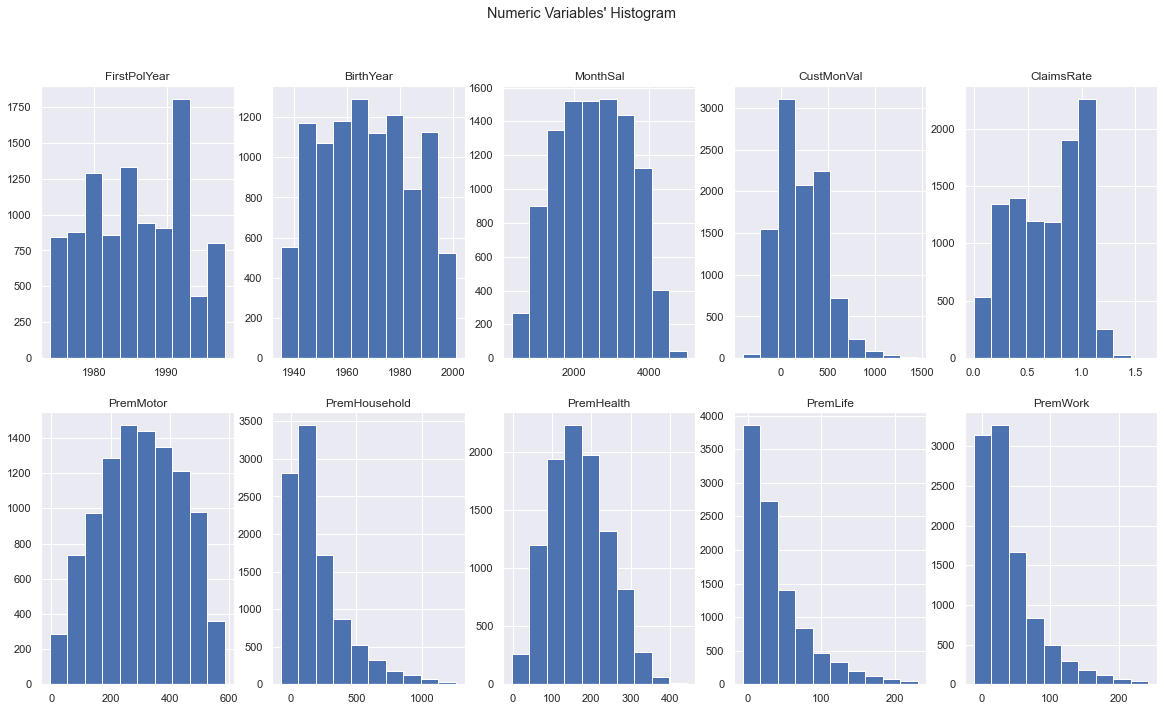

In [41]:
# Histograms for the data after removing the outliers and performing feature engineering.
sns.set()
fig,axes=plt.subplots(2,ceil(len(metric_features)/2),figsize=(20,11))
for ax,feat in zip(axes.flatten(),metric_features):
    ax.hist(df2[feat])
    ax.set_title(feat)
title="Numeric Variables' Histogram"
plt.suptitle(title)
plt.show()

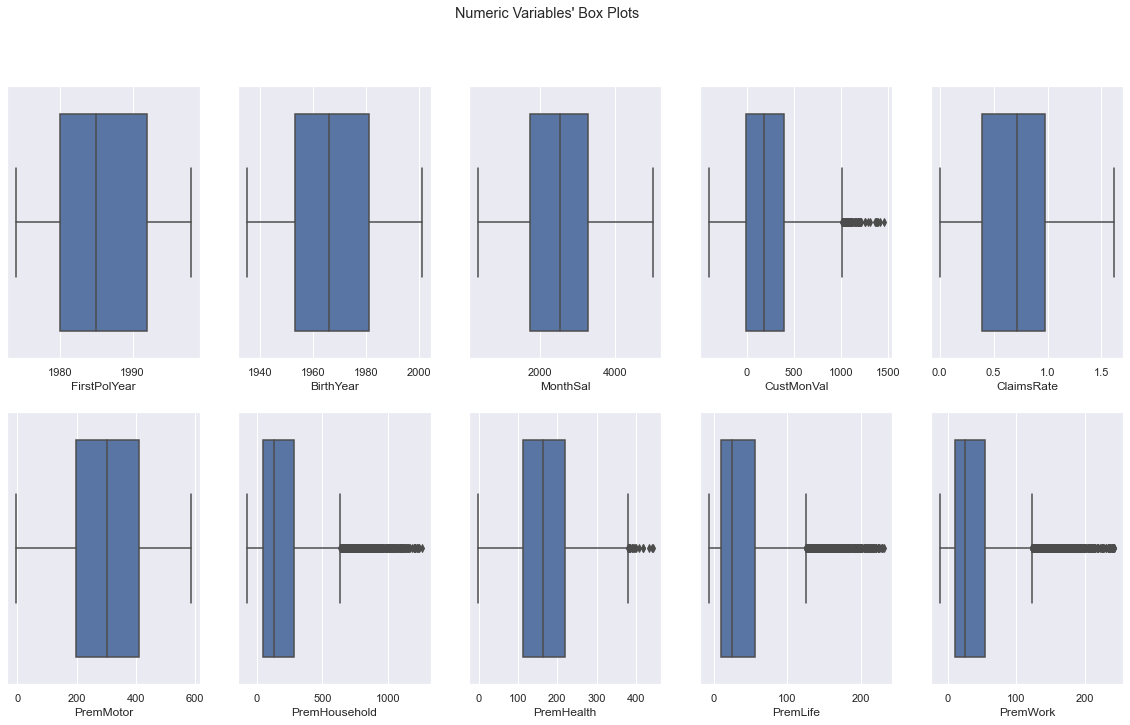

In [42]:
# Box Plots for the data after removing the outliers and performing feature engineering.
sns.set()
fig,axes=plt.subplots(2,ceil(len(metric_features)/2),figsize=(20,11))
for ax,feat in zip(axes.flatten(),metric_features):
    sns.boxplot(x=df2[feat],ax=ax)
title="Numeric Variables' Box Plots"
plt.suptitle(title)
plt.show()

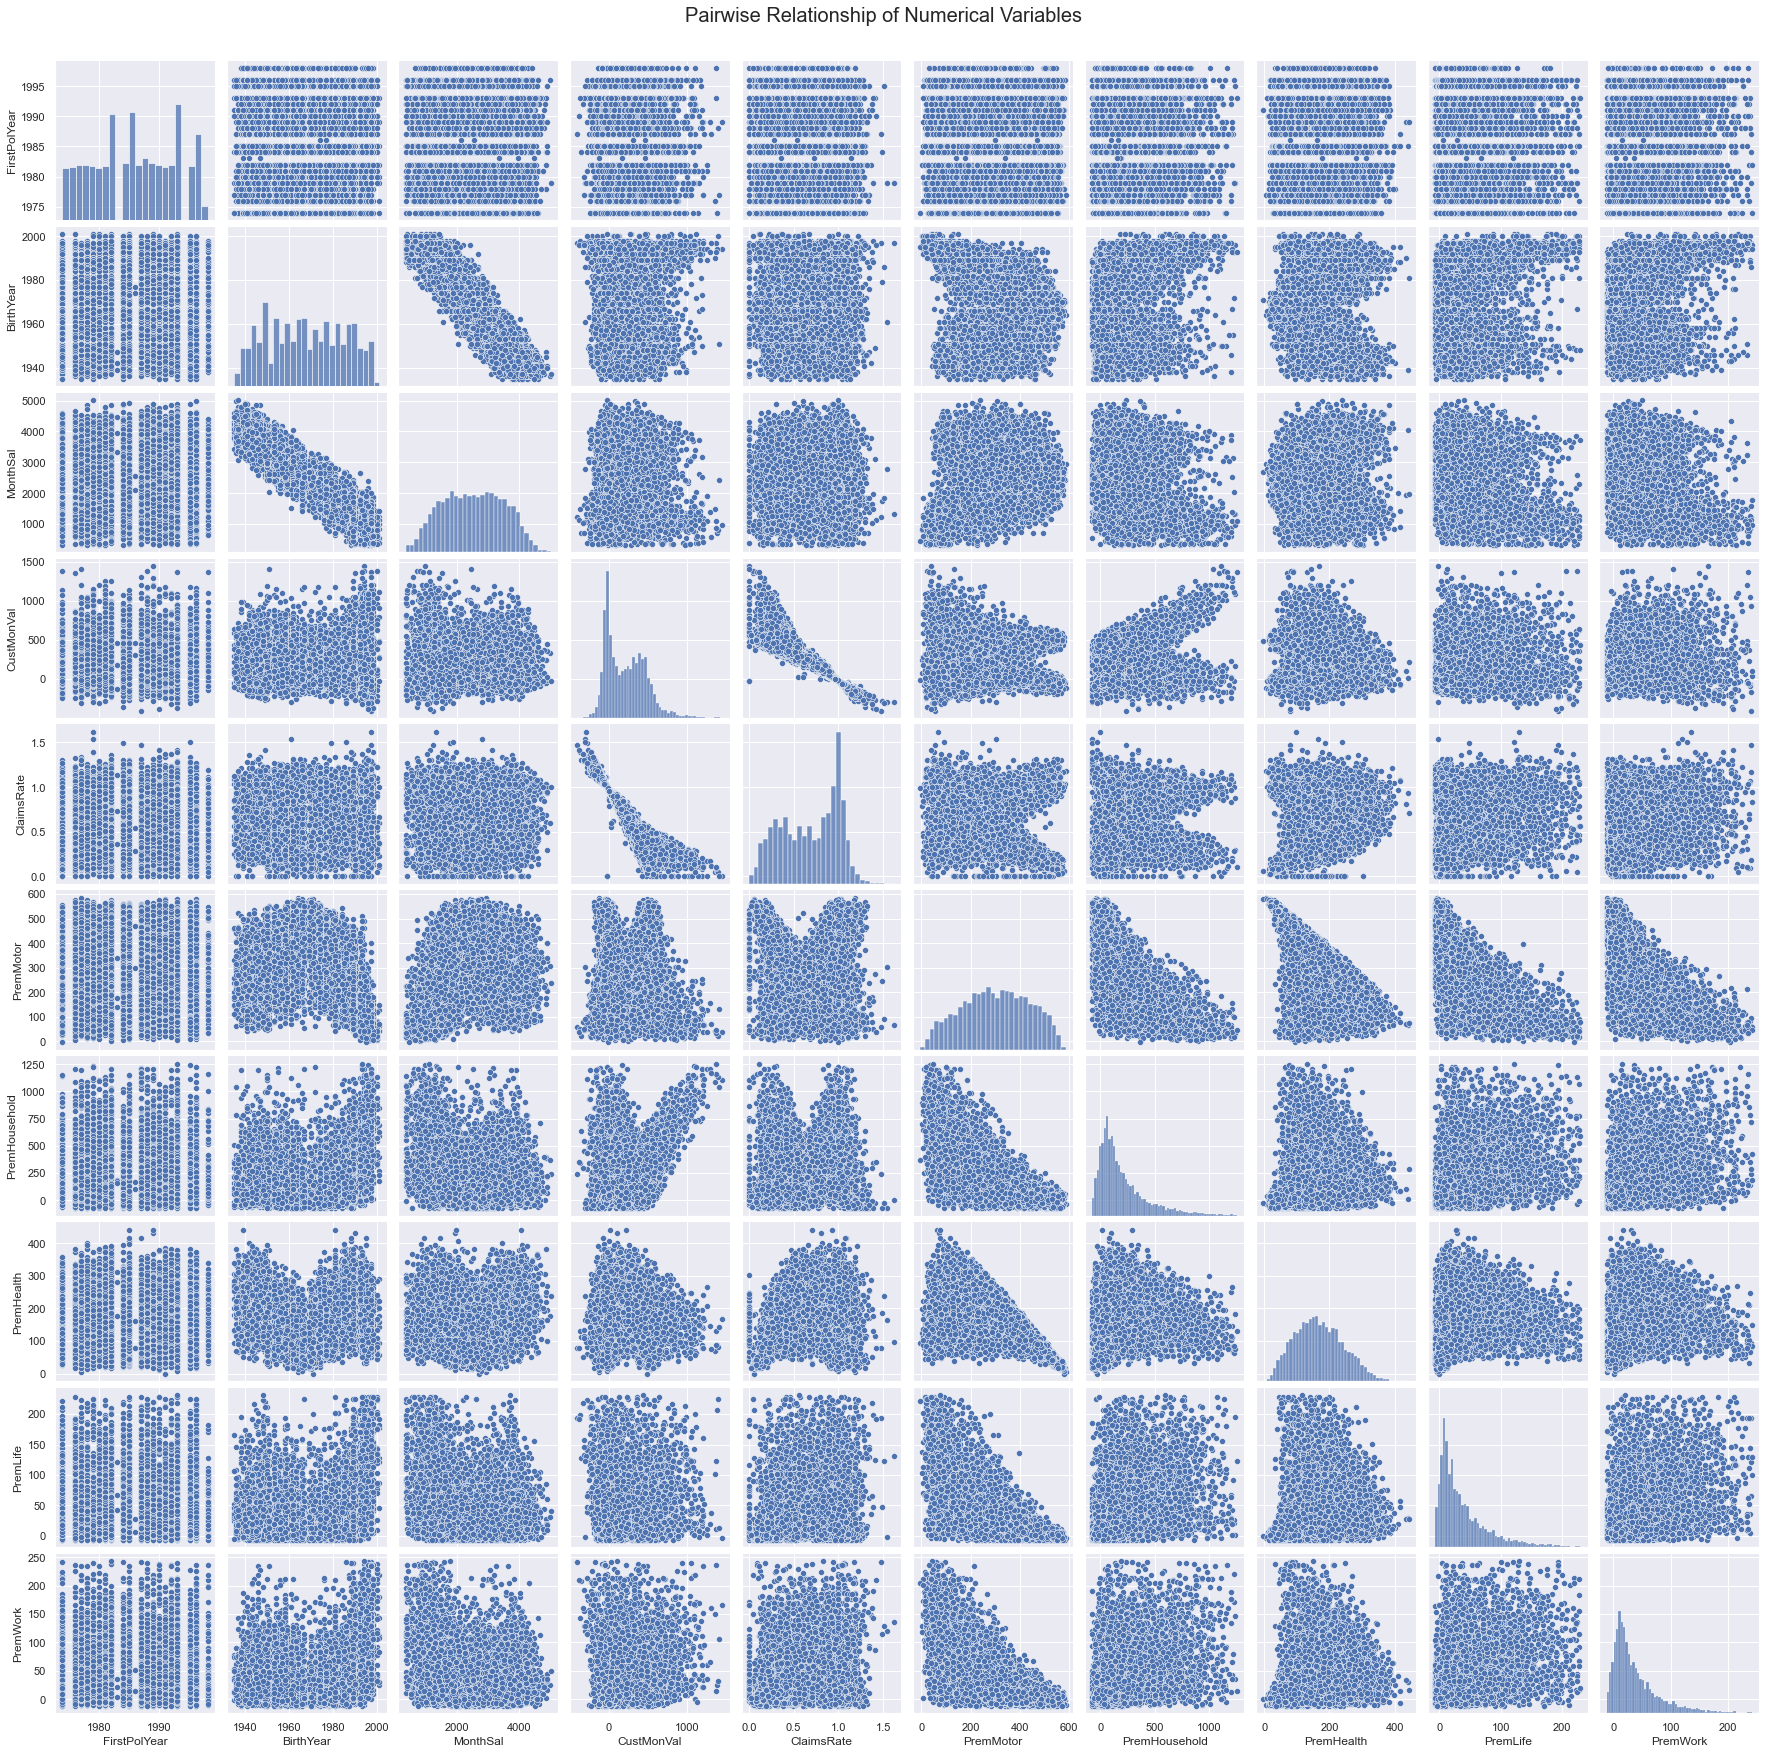

In [43]:
# We still have to eliminate some bivariate outliers. By looking at the pairwise relation
# between the different variables we can see 2 things: The first is that we still have some
# bivariate outliers. The second is that the relation between the variables is not always linear,
# as one would expect. For the Data Exploration use these plots to draw some nice conclusions.
# For example we clearly see the correlation of 1 between total premium and premium household.
# Explore the relation between the premiums. Higher the household premium, lower will be the other
# premiums. Try to find an explanation for this.
sns.set()
sns.pairplot(df2[metric_features],diag_kind="hist")
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise Relationship of Numerical Variables",fontsize=20)
plt.show()

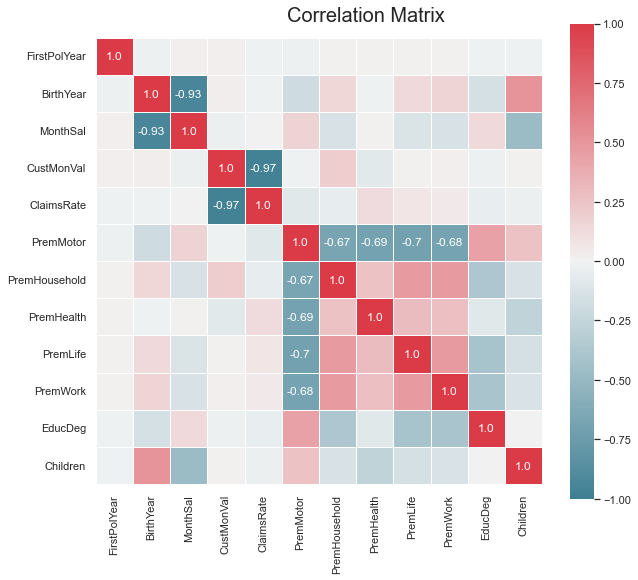

In [44]:
# We use spearman as some of the relations between the variables
# may be non-linear.
metric_features.append("EducDeg")
metric_features.append("Children")
fig=plt.figure(figsize=(10,8))
corr=np.round(df2[metric_features].corr(method="spearman"),decimals=2)
mask_annot=np.absolute(corr.values)>=0.60
annot=np.where(mask_annot, corr.values, np.full(corr.shape,""))
sns.heatmap(data=corr,annot=annot,cmap=sns.diverging_palette(220,10,as_cmap=True), 
            fmt='s',vmin=-1,vmax=1,center=0,square=True,linewidths=.5)
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix",fontsize=20)
plt.show()
metric_features.remove("EducDeg")
metric_features.remove("Children")

### 2.2.3. Feature Engineering

In [45]:
# Creating a copy to perform feature engineering.
df3=df2.copy()

In [46]:
# Further explanation on the variables created will be presented on the report.
df3["Age"]=2016-df3["BirthYear"]
df3["Fidelity"]=2016-df3["FirstPolYear"]
df3["Annual_Salary"]=12*df3["MonthSal"]
df3["Total_Premium"]=df3["PremMotor"]+df3["PremHousehold"]+df3["PremHealth"]+df3["PremLife"]+df3["PremWork"]
df3["Insurance_Burden"]=df3["Total_Premium"]/df3["Annual_Salary"]

In [47]:
# Checking the portion of the total premium that comes from the household premium.
# For the reversal we set the ratio to be 0, as we don't want negative ratios.
df3["Household_Ratio"]=df3["PremHousehold"]/df3["Total_Premium"]
household_negative=df3[df3["PremHousehold"]<0].index
df3.loc[household_negative,"Household_Ratio"]=0

In [48]:
# Checking the portion of the total premium that comes from the health premium.
# For the reversal we set the ratio to be 0, as we don't want negative ratios.
df3["Health_Ratio"]=df3["PremHealth"]/df3["Total_Premium"]
health_negative=df3[df3["PremHealth"]<0].index
df3.loc[health_negative,"Health_Ratio"]=0

In [49]:
# Checking the portion of the total premium that comes from the life premium.
# For the reversal we set the ratio to be 0, as we don't want negative ratios.
df3["Life_Ratio"]=df3["PremLife"]/df3["Total_Premium"]
life_negative=df3[df3["PremLife"]<0].index
df3.loc[life_negative,"Life_Ratio"]=0

In [50]:
# Checking the portion of the total premium that comes from the work premium.
# For the reversal we set the ratio to be 0, as we don't want negative ratios.
df3["Work_Ratio"]=df3["PremWork"]/df3["Total_Premium"]
work_negative=df3[df3["PremWork"]<0].index
df3.loc[work_negative,"Work_Ratio"]=0

In [51]:
# Checking the portion of the total premium that comes from the motor premium.
# For the reversal we set the ratio to be 0, as we don't want negative ratios.
df3["Motor_Ratio"]=df3["PremMotor"]/df3["Total_Premium"]
motor_negative=df3[df3["PremMotor"]<0].index
df3.loc[motor_negative,"Motor_Ratio"]=0

In [52]:
# Creating a dummy variable that takes the value 1 if any of the insurance premiums was cancelled,
# and takes the value 0 if we didn't have the cancellation of any insurance of the insurances.
df3["Cessation"]=0
df3.loc[household_negative,"Cessation"]=1
df3.loc[health_negative,"Cessation"]=1
df3.loc[life_negative,"Cessation"]=1
df3.loc[work_negative,"Cessation"]=1
df3.loc[motor_negative,"Cessation"]=1

In [53]:
# Dropping from the dataset features that explain exactly the same as the ones created,
# and won't be useful going ahead.
df3.drop(columns=["BirthYear"],inplace=True)
df3.drop(columns=["FirstPolYear"],inplace=True)
df3.drop(columns=["MonthSal"],inplace=True)

In [54]:
# Appending to, and removing from our list the new and old variables.
metric_features.append("Age")
metric_features.append("Fidelity")
metric_features.append("Annual_Salary")
metric_features.append("Total_Premium")
metric_features.append("Household_Ratio")
metric_features.append("Health_Ratio")
metric_features.append("Life_Ratio")
metric_features.append("Work_Ratio")
metric_features.append("Motor_Ratio")
metric_features.append("Insurance_Burden")
metric_features.append("Cessation")
metric_features.remove("BirthYear")
metric_features.remove("FirstPolYear")
metric_features.remove("MonthSal")

In [55]:
# Checking if everything was performed correctly.
df3.head()

,EducDeg,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,...,Fidelity,Annual_Salary,Total_Premium,Insurance_Burden,Household_Ratio,Health_Ratio,Life_Ratio,Work_Ratio,Motor_Ratio,Cessation
CustID,,,,,,,,,,,,,,,,,,,,,
1.0,2,1,1,380.97,0.39,375.85,79.45,146.36,47.01,16.89,...,31,26124.0,665.56,0.025477,0.119373,0.219905,0.070632,0.025377,0.564712,0
2.0,2,4,1,-131.13,1.12,77.46,416.20,116.69,194.48,106.13,...,35,8124.0,910.96,0.112132,0.456881,0.128096,0.213489,0.116503,0.085031,0
3.0,1,3,0,504.67,0.28,206.15,224.50,124.58,86.35,99.02,...,25,27324.0,740.60,0.027104,0.303133,0.168215,0.116595,0.133702,0.278355,0
4.0,3,4,1,-16.99,0.99,182.48,43.35,311.17,35.34,28.34,...,26,13188.0,600.68,0.045547,0.072168,0.518030,0.058833,0.047180,0.303789,0
5.0,3,4,1,35.23,0.90,338.62,47.80,182.59,18.78,41.45,...,31,21156.0,629.24,0.029743,0.075965,0.290175,0.029846,0.065873,0.538141,0


## 2.4. Advanced Data Visualization (After-Feature Engineering and After-Outlier Removal)

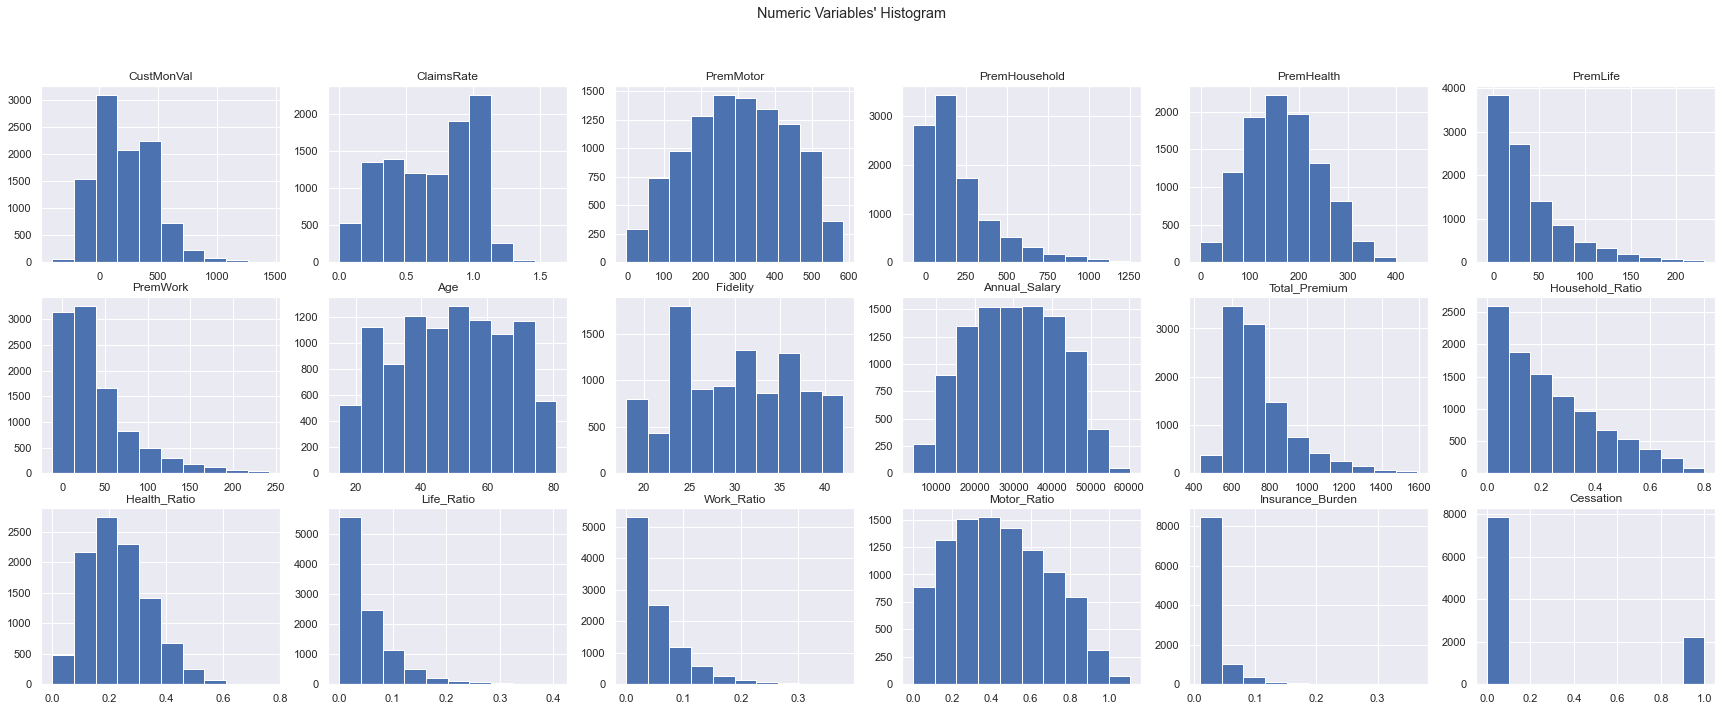

In [56]:
# Histograms for the data after removing the outliers and performing feature engineering.
sns.set()
fig,axes=plt.subplots(3,ceil(len(metric_features)/3),figsize=(30,11))
for ax,feat in zip(axes.flatten(),metric_features):
    ax.hist(df3[feat])
    ax.set_title(feat)
title="Numeric Variables' Histogram"
plt.suptitle(title)
plt.show()

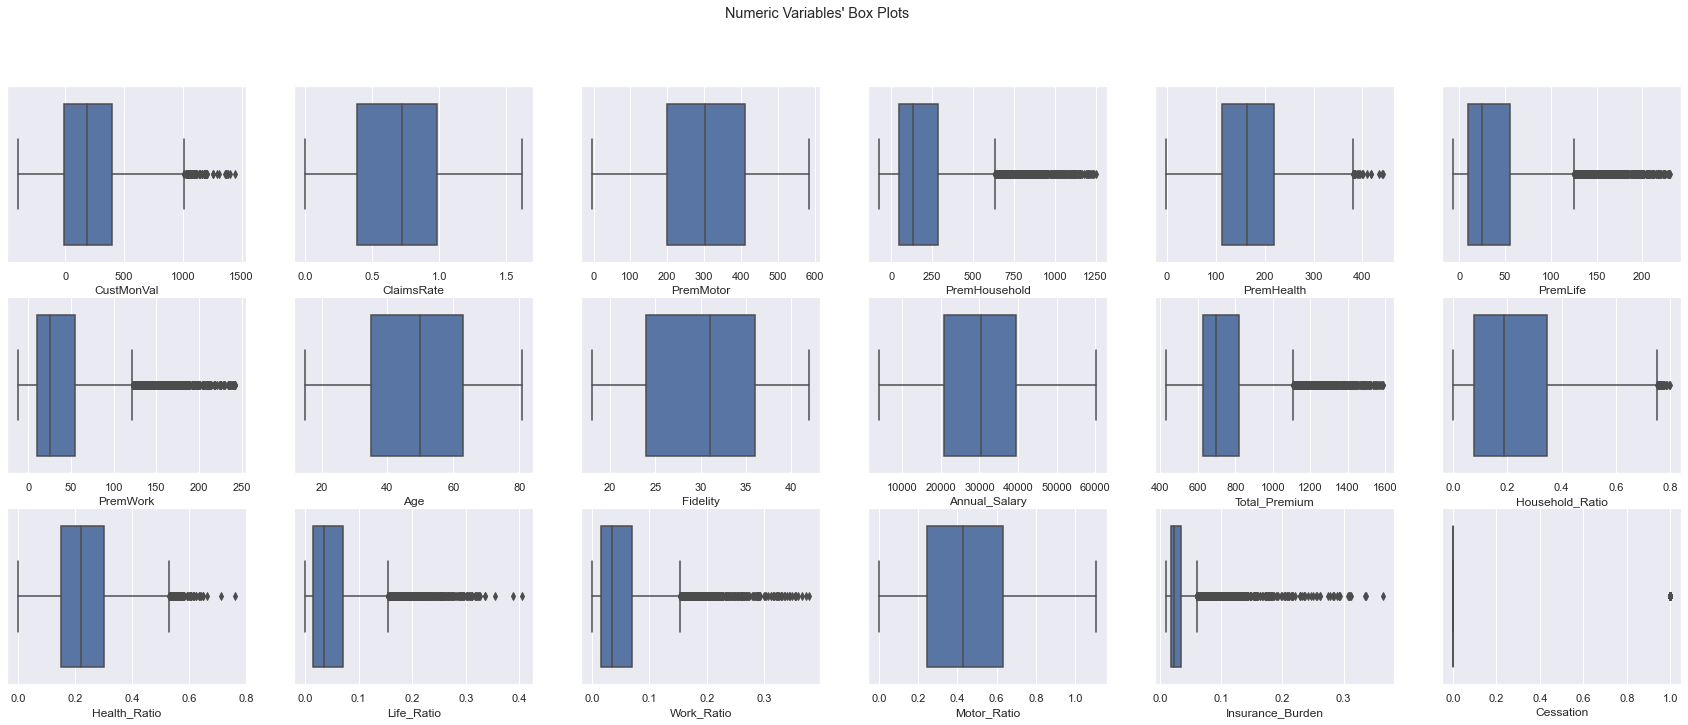

In [57]:
# Box Plots for the data after removing the outliers and performing feature engineering.
sns.set()
fig,axes=plt.subplots(3,ceil(len(metric_features)/3),figsize=(30,11))
for ax,feat in zip(axes.flatten(),metric_features):
    sns.boxplot(x=df3[feat],ax=ax)
title="Numeric Variables' Box Plots"
plt.suptitle(title)
plt.show()

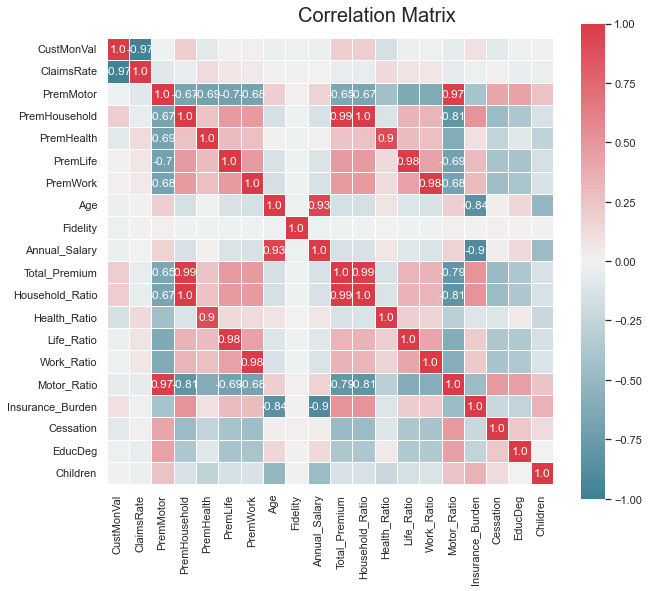

In [58]:
# We use spearman as some of the relations between the variables
# may be non-linear.
metric_features.append("EducDeg")
metric_features.append("Children")
fig=plt.figure(figsize=(10,8))
corr=np.round(df3[metric_features].corr(method="spearman"),decimals=2)
mask_annot=np.absolute(corr.values)>=0.65
annot=np.where(mask_annot, corr.values, np.full(corr.shape,""))
sns.heatmap(data=corr,annot=annot,cmap=sns.diverging_palette(220,10,as_cmap=True), 
            fmt='s',vmin=-1,vmax=1,center=0,square=True,linewidths=.5)
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix",fontsize=20)
plt.show()
metric_features.remove("EducDeg")
metric_features.remove("Children")

# 3. Segmentation

In [59]:
# We decided to segment in 3 different segments, which then we are going to apply
# different clustering algorithms to them and try to understand which technique
# works better with each one of them. For each one of the segments we are going
# to create different dataframes with different variations of the variables and
# find out which dataframe works the best.

In [60]:
# Before dividing them, we are going to scale the data, as we want each variable
# to have the same weight in our clustering algorithm. This is needed because
# normally the clustering algorithms use euclidean distances as the similarity
# metric.

metric_features.append("EducDeg")
metric_features.append("Children")

# Performing Standard Scaling and creating df4_standard.
df4=df3[metric_features].copy()
scaling1=StandardScaler()
scaling1.fit(df4)
df4_standard=scaling1.transform(df4)
df4_standard=pd.DataFrame(data=df4_standard, index=df4.index, columns=df4.columns)

# Performing Min Max Scaling and creating df3_minmax.
scaling2=MinMaxScaler()
scaling2.fit(df4)
df4_minmax=scaling2.transform(df4)
df4_minmax=pd.DataFrame(data=df4_minmax, index=df4.index, columns=df4.columns)

In [61]:
# For the Customer Demographic Segment we chose "Age", "Children", "EducDeg", and "Annual_Salary",
# as the variables to use. We will create different variants of this dataframe to understand
# then which are the better ones to include and with which scaling, for example.
cust_demographic=["Age","Children","EducDeg","Annual_Salary"]

# As "Age" and "Annual_Salary" are highly correlated we can only include one of them at a time,
# so we are going to use different dataframes to check which one is the better for clustering.
# Nonetheless, we are always going to include the excluded one on the final analysis.
cust_demographic1=["Children","EducDeg","Annual_Salary"]
cust_demographic2=["Age","Children","EducDeg"]

# Creating the dataframes using cust_demographic1.
demo_df1_minmax=df4_minmax[cust_demographic1]
demo_df1_standard=df4_standard[cust_demographic1]

# Creating the dataframes using cust_demographic2.
demo_df2_minmax=df4_minmax[cust_demographic2]
demo_df2_standard=df4_standard[cust_demographic2]

In [62]:
# For the Insurance Package Segment we chose "PremMotor", "PremHousehold", "PremHealth", "PremLife", "PremWork"
# as the variables to use. We will create different variants of this dataframe to understand
# then which are the better ones to include and with which scaling, for example.
insur_package=["PremMotor","PremHousehold","PremHealth","PremLife","PremWork"]

# "PreMotor" is highly correlated with the other premiums so we will exclude it from the clustering
# but when analysing the clusters we are going to include it again so we can get insights with it.
insur_package1=["PremHousehold","PremHealth","PremLife","PremWork"]
pack_df1_minmax=df4_minmax[insur_package1]
pack_df1_standard=df4_standard[insur_package1]

In [63]:
# For the Customer Importance Segment we chose "CustMonVal", "ClaimsRate", "Total_Premium",
# "Cessation", and "Insurance_Burden" as the variables to use. We will create different
# variants of this dataframe to understand then which are the better ones to include and
# with which scaling, for example.
cust_importance=["CustMonVal", "ClaimsRate", "Total_Premium", "Cessation", "Insurance_Burden"]

# As "ClaimsRate" and "CustMonVal" are highly correlated we can only have one of them at
# a time, we will create two option, one with each one of them at a time, and check which
# is the dataframe that gives clearer clusters.
cust_importance1=["ClaimsRate", "Total_Premium", "Cessation", "Insurance_Burden"]
cust_importance2=["CustMonVal", "Total_Premium", "Cessation", "Insurance_Burden"]

# Creating the dataframes using cust_importance1.
import_df1_minmax=df4_minmax[cust_importance1]
import_df1_standard=df4_standard[cust_importance1]

# Creating the dataframes using cust_importance2.
import_df2_minmax=df4_minmax[cust_importance2]
import_df2_standard=df4_standard[cust_importance2]